<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220623.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* regressor
* customer analysis

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotnine as gg
from plotnine import ggplot, aes 
from datetime import datetime, date, time, timezone, timedelta
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score, mean_squared_error
import sklearn.datasets as skd

# Regressor

In [5]:
raw = skd.fetch_california_housing()
x = pd.DataFrame(raw['data'], columns = raw['feature_names'])
y = raw['target']
x.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [6]:
x.columns = [a.lower() for a in x.columns]
x.head()

,medinc,houseage,averooms,avebedrms,population,aveoccup,latitude,longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [32]:
scaler = StandardScaler()
x_ = scaler.fit_transform(pd.DataFrame(np.c_[x.values, y.reshape(-1,1)]))
x_ = pd.DataFrame(x_, columns = list(x.columns) + ['price'])
x_.head()

,medinc,houseage,averooms,avebedrms,population,aveoccup,latitude,longitude,price
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835,2.129631
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844,1.314156
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827,1.258693
3,0.932968,1.856182,0.156966,-0.049833,-0.766028,-0.050329,1.038503,-1.337818,1.165100
4,-0.012881,1.856182,0.344711,-0.032906,-0.759847,-0.085616,1.038503,-1.337818,1.172900


In [33]:
km_score = [KMeans(n_clusters= a ).fit(x_).inertia_ for a in range(1,11)]

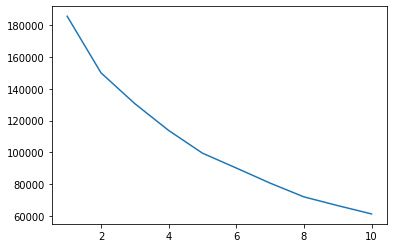

In [34]:
plt.plot(range(1,11), km_score)

In [35]:
km = KMeans(n_clusters = 8).fit(x_)

In [36]:
km.labels_

array([4, 4, 4, ..., 1, 1, 1], dtype=int32)

In [37]:
pca = PCA(n_components = 8)
fit_pca = pca.fit_transform(x_)

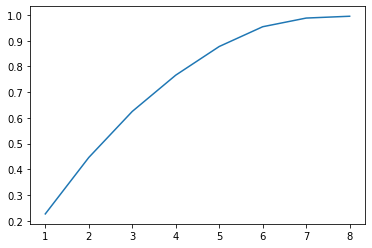

In [38]:
plt.plot(range(1, 9), pca.explained_variance_ratio_.cumsum())

In [39]:
fit_pca = pd.DataFrame(np.c_[fit_pca, km.labels_.reshape(-1,1)], columns = [f'pc{a}' for a in range(1, 9)] + ['cl'])
fit_pca.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,cl
0,2.346543,0.346441,-3.028503,-0.579781,0.115562,-0.017059,-0.259174,0.066251,4.0
1,1.761367,0.438124,-2.151692,1.710048,-0.276682,0.148532,-0.478215,0.335532,4.0
2,2.330312,-0.126208,-2.236715,-1.145055,0.359770,0.610755,-0.861687,-0.219425,4.0
3,1.537078,-0.810004,-2.019956,-1.174627,0.312851,0.727201,-0.202632,0.077864,4.0
4,1.416914,-1.121116,-1.493024,-1.331380,0.291763,0.898160,0.312936,-0.350550,4.0


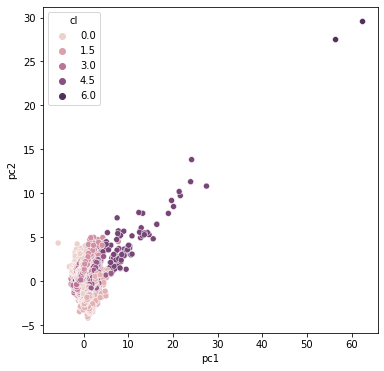

In [40]:
plt.figure(figsize = [6,6])
sns.scatterplot(data = fit_pca, x = 'pc1', y = 'pc2', hue = 'cl')

In [45]:
x_labeled =  pd.DataFrame(np.c_[x.values, y.reshape(-1,1),km.labels_.reshape(-1,1)], 
                          columns = list(x.columns) + ['price','cl'])
x_labeled.groupby(['cl']).agg('mean').reset_index().sort_values(['price'], ascending = [0])

,cl,medinc,houseage,averooms,avebedrms,population,aveoccup,latitude,longitude,price
2,2.0,6.278253,27.395113,6.444323,1.065971,1210.922513,2.735325,33.882726,-118.148558,3.644735
4,4.0,5.569507,32.753247,5.981247,1.044167,1216.368831,2.691439,37.626141,-122.140386,3.368629
6,6.0,3.250000,33.500000,137.221212,29.851515,33.000000,2.563636,38.855000,-120.090000,3.312505
0,0.0,3.896361,15.234061,5.300048,1.078128,4614.032314,4.480625,34.779528,-118.680873,1.889951
3,3.0,3.124038,30.478408,4.754581,1.070881,1315.651396,3.135141,33.911289,-117.946182,1.662534
5,5.0,3.431817,18.103448,27.532848,5.688664,359.965517,2.505633,37.486667,-119.233103,1.590540
7,7.0,10.226400,45.000000,3.166667,0.833333,7460.000000,1243.333333,38.320000,-121.980000,1.375000
1,1.0,2.930168,27.619536,5.250382,1.096681,1168.337432,2.842346,38.054635,-121.475009,1.294752


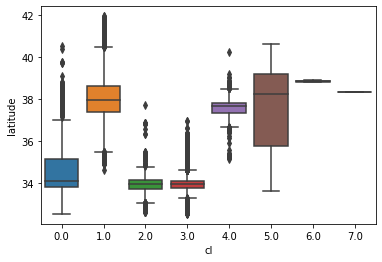

In [50]:
sns.boxplot(x = 'cl', y = 'latitude', data = x_labeled)

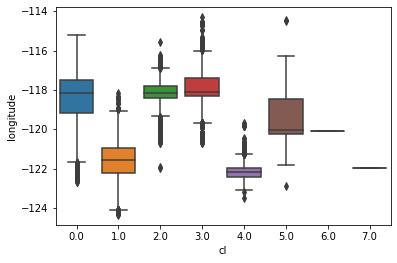

In [51]:
sns.boxplot(x = 'cl', y = 'longitude', data = x_labeled)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning: No contour levels were found within the data range.
  **contour_kws,


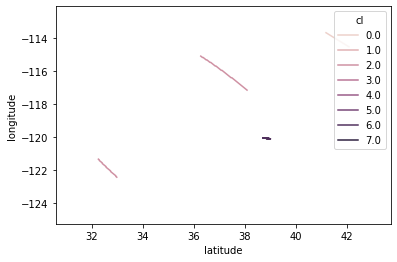

In [52]:
sns.kdeplot(data = x_labeled, x = 'latitude', y = 'longitude', hue = 'cl')

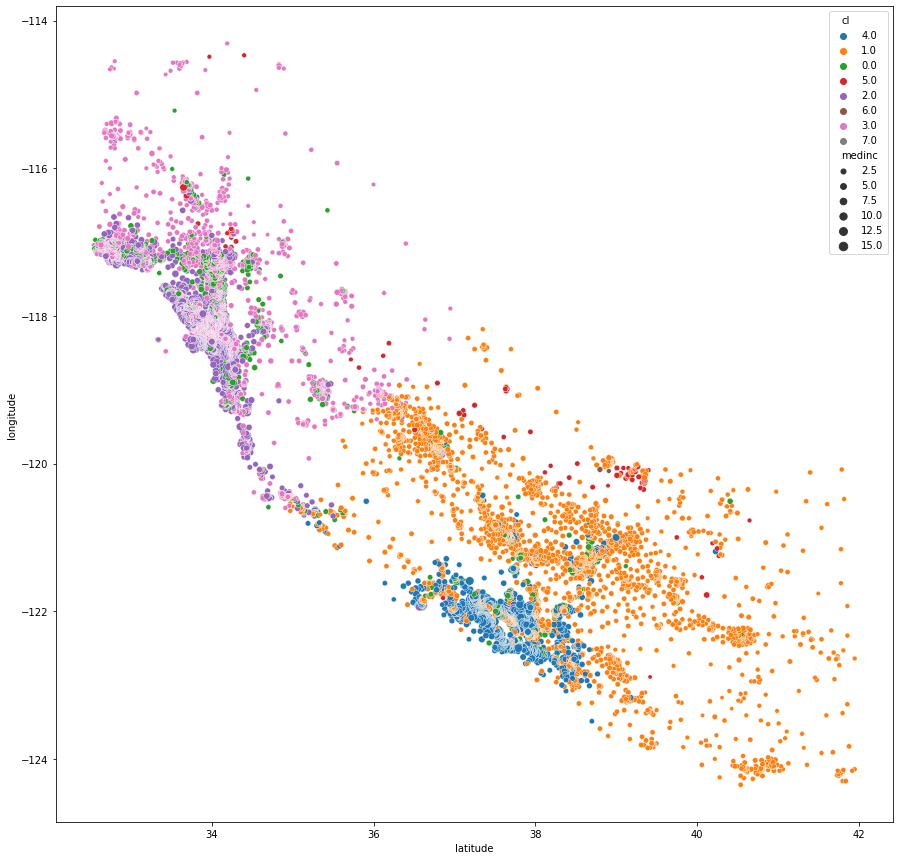

In [64]:
plt.figure(figsize = [15,15])
sns.scatterplot(data = x_labeled.assign(cl = x_labeled['cl'].astype(str)), 
                x = 'latitude', y = 'longitude', hue = 'cl', size = 'medinc')

In [65]:
x_tr, x_te, y_tr, y_te = train_test_split(x, y, train_size = .7)

In [67]:
fit_lr = LinearRegression().fit(x_tr,y_tr)
fit_rf = RandomForestRegressor().fit(x_tr, y_tr)

In [68]:
pred_lr = fit_lr.predict(x_te)
pred_rf= fit_rf.predict(x_te)

In [69]:
mean_squared_error(y_te, pred_lr), mean_squared_error(y_te, pred_rf)

(0.518122788245059, 0.26888918803525935)

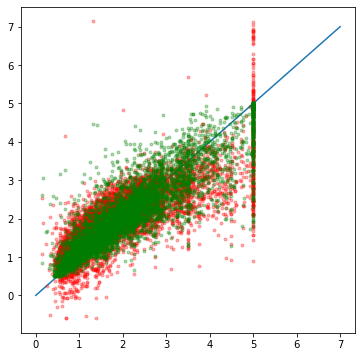

In [71]:
plt.figure(figsize = [6,6])
plt.plot([0, 7], [0,7])
plt.plot(y_te, pred_lr, '.', color = 'red', alpha = .3)
plt.plot(y_te, pred_rf, '.', color = 'green', alpha = .3)

# Customer Analysis

In [72]:
os.listdir()

['.config',
 'test.csv',
 'rfm_test.csv',
 'online_retail_II.xlsx',
 'retail_data_transactions.csv',
 'ecommerce-data.csv',
 '.Rhistory',
 'sample_submission.csv',
 'item_categories.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'items.csv',
 'shops.csv',
 'sales_train.csv',
 'retail_data_response.csv',
 'sample_data']

In [75]:
df=  pd.read_csv('retail_data_transactions.csv')
df.columns = ['id', 'date', 'rev']
df.head()

,id,date,rev
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [76]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].to_numpy().astype('datetime64[M]')
df.head()

,id,date,rev,month
0,CS5295,2013-02-11,35,2013-02-01
1,CS4768,2015-03-15,39,2015-03-01
2,CS2122,2013-02-26,52,2013-02-01
3,CS1217,2011-11-16,99,2011-11-01
4,CS1850,2013-11-20,78,2013-11-01


In [78]:
df = df.sort_values(['id', 'date'], ascending = [1,0])
df.head()

,id,date,rev,month
5650,CS1112,2015-01-14,39,2015-01-01
31500,CS1112,2014-12-04,59,2014-12-01
17810,CS1112,2014-07-16,90,2014-07-01
26626,CS1112,2014-04-29,63,2014-04-01
74842,CS1112,2013-11-13,71,2013-11-01


In [79]:
df = df.groupby(['id', 'month', 'date'])['rev'].sum().reset_index()
df.head()

,id,month,date,rev
0,CS1112,2011-06-01,2011-06-15,56
1,CS1112,2011-08-01,2011-08-19,96
2,CS1112,2011-10-01,2011-10-02,60
3,CS1112,2012-04-01,2012-04-08,56
4,CS1112,2012-06-01,2012-06-24,52


In [81]:
df = df.sort_values(['id', 'month'], ascending = [1, 0])
df.head()

,id,month,date,rev
14,CS1112,2015-01-01,2015-01-14,39
13,CS1112,2014-12-01,2014-12-04,59
12,CS1112,2014-07-01,2014-07-16,90
11,CS1112,2014-04-01,2014-04-29,63
10,CS1112,2013-11-01,2013-11-13,71


In [90]:
info_m = df.groupby(['id', 'month'])['rev'].sum().reset_index().rename(columns= {'rev':'money'})
info_m = pd.pivot_table(info_m, index = 'id', columns = 'month', values = 'money').reset_index()
info_m = pd.melt(info_m, id_vars = 'id', var_name = 'month', value_name = 'money').sort_values(['id', 'month'], ascending = [1, 0])
info_m = info_m.groupby(['id']).head(3)
info_m = info_m.groupby('id')['money'].sum().reset_index()
info_m.head()

,id,money
0,CS1112,39.0
1,CS1113,220.0
2,CS1114,79.0
3,CS1115,55.0
4,CS1116,0.0


In [91]:
info_f = df.groupby(['id', 'month'])['rev'].count().reset_index().rename(columns= {'rev':'freq'})
info_f = pd.pivot_table(info_f, index = 'id', columns = 'month', values = 'freq').reset_index()
info_f = pd.melt(info_f, id_vars = 'id', var_name = 'month', value_name = 'freq').sort_values(['id', 'month'], ascending = [1, 0])
info_f = info_f.groupby(['id']).head(3)
info_f = info_f.groupby('id')['freq'].sum().reset_index()
info_f.head()

,id,freq
0,CS1112,1.0
1,CS1113,2.0
2,CS1114,1.0
3,CS1115,1.0
4,CS1116,0.0


In [93]:
df['date'].max()

Timestamp('2015-03-16 00:00:00')

In [95]:
date_now = datetime(2015, 3, 31)
date_now

datetime.datetime(2015, 3, 31, 0, 0)

In [103]:
info_r = df.groupby(['id']).agg({'date': lambda x : (date_now - x.max()).days}).reset_index().rename(columns = {'date':'recency'})
info_r.head()

,id,recency
0,CS1112,76
1,CS1113,50
2,CS1114,47
3,CS1115,26
4,CS1116,218


In [104]:
info = pd.merge(pd.merge(info_r, info_f, 'left', 'id'), info_m, 'left', 'id')
info.head()

,id,recency,freq,money
0,CS1112,76,1.0,39.0
1,CS1113,50,2.0,220.0
2,CS1114,47,1.0,79.0
3,CS1115,26,1.0,55.0
4,CS1116,218,0.0,0.0


In [108]:
info = info.assign(r = pd.qcut(info['recency'], 5, list('12345')),
            f = pd.qcut(info['freq'].rank(method = 'first'), 5, list('54321')),
            m = pd.qcut(info['money'].rank(method = 'first'), 5, list('54321'))
            )
info.head()

,id,recency,freq,money,r,f,m
0,CS1112,76,1.0,39.0,3,4,3
1,CS1113,50,2.0,220.0,2,2,1
2,CS1114,47,1.0,79.0,2,4,2
3,CS1115,26,1.0,55.0,1,4,3
4,CS1116,218,0.0,0.0,5,5,5


In [110]:
info = info.assign(rf = info['r'].astype(str) + info['f'].astype(str))
info.head()

,id,recency,freq,money,r,f,m,rf
0,CS1112,76,1.0,39.0,3,4,3,34
1,CS1113,50,2.0,220.0,2,2,1,22
2,CS1114,47,1.0,79.0,2,4,2,24
3,CS1115,26,1.0,55.0,1,4,3,14
4,CS1116,218,0.0,0.0,5,5,5,55


In [111]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

In [112]:
info.assign(rf = info['rf'].replace(seg_map, regex = True))

,id,recency,freq,money,r,f,m,rf
0,CS1112,76,1.0,39.0,3,4,3,loyal_customers
1,CS1113,50,2.0,220.0,2,2,1,hibernating
2,CS1114,47,1.0,79.0,2,4,2,at_Risk
3,CS1115,26,1.0,55.0,1,4,3,at_Risk
4,CS1116,218,0.0,0.0,5,5,5,champions
...,...,...,...,...,...,...,...,...
6884,CS8996,112,0.0,0.0,4,4,4,loyal_customers
6885,CS8997,276,0.0,0.0,5,4,4,champions
6886,CS8998,99,0.0,0.0,4,4,4,loyal_customers
6887,CS8999,272,0.0,0.0,5,4,4,champions
